In [1]:
import hankl
import mcfit
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline as Spline

input_dir = ''

In [2]:
def read(i):
    filename = 'win_BOSS_DR12_SGC_z1_COMPnbar_TSC_V6S_600_600_600_10000_%s.000000.dat' % i
    data = np.loadtxt(input_dir+filename, skiprows=31)
    
    k_central = data[:,0]
    k_mean = data[:,1]
    wk0 = data[:,2]
    wk2 = data[:,4]
    wk4 = data[:,6]
    nmodes = data[:,-1]
    
    #k_mean[k_mean==0] = k_central[k_mean==0]
    
    return k_central, k_mean, wk0, wk2, wk4, nmodes


def reduce(theta, l):
    
    k_central, k_mean, wk0, wk2, wk4, nmodes = theta
        
    k_central_new = np.empty(len(k_central)//l)
    k_mean_new = np.empty(len(k_central)//l)
    wk0_new = np.empty(len(k_central)//l)
    wk2_new = np.empty(len(k_central)//l)
    wk4_new = np.empty(len(k_central)//l)
    nmodes_new = np.empty(len(k_central)//l)
    
    for i in range(len(k_central)//l):
        k_central_new[i] = np.sum(k_central[i*l:(i+1)*l])/l
        k_mean_new[i] = np.sum(k_mean[i*l:(i+1)*l]*nmodes[i*l:(i+1)*l])/np.max([np.sum(nmodes[i*l:(i+1)*l]),1])
        wk0_new[i] = np.sum(wk0[i*l:(i+1)*l]*nmodes[i*l:(i+1)*l])/np.max([np.sum(nmodes[i*l:(i+1)*l]),1])
        wk2_new[i] = np.sum(wk2[i*l:(i+1)*l]*nmodes[i*l:(i+1)*l])/np.max([np.sum(nmodes[i*l:(i+1)*l]),1])
        wk4_new[i] = np.sum(wk4[i*l:(i+1)*l]*nmodes[i*l:(i+1)*l])/np.max([np.sum(nmodes[i*l:(i+1)*l]),1])
        nmodes_new[i] = np.sum(nmodes[i*l:(i+1)*l])
            
    k_mean_new[k_mean_new==0] = k_central_new[k_mean_new==0]
    
    return k_central_new, k_mean_new, wk0_new, wk2_new, wk4_new, nmodes_new

In [3]:
k_central, k_mean, wk0, wk2, wk4, nmodes = reduce(read(100000),4)

In [4]:
kext = np.linspace(k_mean[-1]+0.001,1000.0,100)
wext = np.zeros(100)

k_mean = np.hstack((k_mean,kext))
wk0 = np.hstack((wk0,wext))
wk2 = np.hstack((wk2,wext))
wk4 = np.hstack((wk4,wext))

In [5]:
W0spline = Spline(k_mean, wk0/wk0[0], k=1)
W2spline = Spline(k_mean, wk2/wk0[0], k=1)
W4spline = Spline(k_mean, wk4/wk0[0], k=1)

k = np.logspace(np.log10(k_mean[0]),np.log10(k_mean[-1]),10000)

W0 = W0spline(k)
W2 = W2spline(k)
W4 = W4spline(k)

In [6]:
r, f_r = hankl.P2xi(k,W0,l=0)
r0 = r[r>10.0]
xi0 = f_r[r>10.0]

r2, f_r2 = hankl.P2xi(k,W2,l=2)
xi2 = f_r2[r2>10.0]
r2 = r2[r2>10.0]

r4, f_r4 = hankl.P2xi(k,W4,l=4)
xi4 = f_r4[r4>10.0]
r4 = r4[r4>10.0]

In [7]:
s0b, xi0b = mcfit.P2xi(k, l=0, lowring=True)(W0)
s2b, xi2b = mcfit.P2xi(k, l=2, lowring=True)(W2)
s4b, xi4b = mcfit.P2xi(k, l=4, lowring=True)(W4)

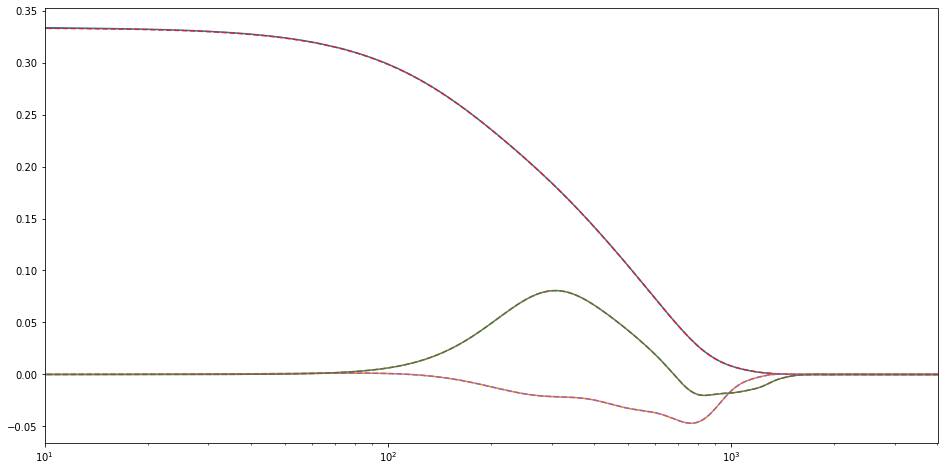

In [8]:
plt.figure(figsize=(16,8))
plt.semilogx(r0,xi0/xi0[0]/3)
plt.semilogx(r2,xi2/xi0[0])
plt.semilogx(r4,xi4/xi0[0])
plt.semilogx(s0b,xi0b/xi0b[0]/3, '--')
plt.semilogx(s2b,xi2b/xi0b[0], '--')
plt.semilogx(s4b,xi4b/xi0b[0], '--')
plt.xlim(10,4000)
plt.show()

In [9]:
k0b, W0b = mcfit.xi2P(s0b, l=0, lowring=True)(xi0b)
k2b, W2b = mcfit.xi2P(s2b, l=2, lowring=True)(xi2b)
k4b, W4b = mcfit.xi2P(s4b, l=4, lowring=True)(xi4b)

In [10]:
k0, W0 = hankl.xi2P(s0b, xi0b, l=0)
k2, W2 = hankl.xi2P(s2b, xi2b, l=2)
k4, W4 = hankl.xi2P(s4b, xi4b, l=4)

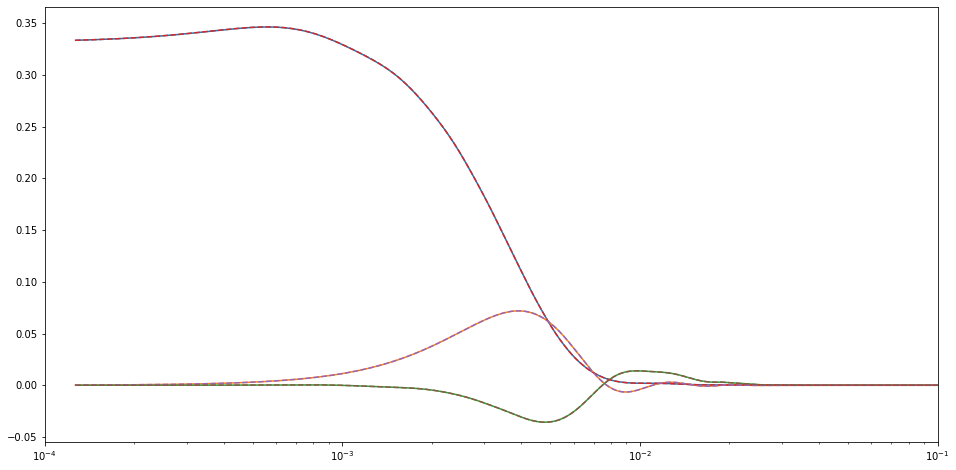

In [11]:
plt.figure(figsize=(16,8))
plt.semilogx(k0,W0/W0[0]/3)
plt.semilogx(k2,W2/W0[0])
plt.semilogx(k4,W4/W0[0])
plt.semilogx(k0b,W0b/W0b[0]/3, '--')
plt.semilogx(k2b,W2b/W0b[0], '--')
plt.semilogx(k4b,W4b/W0b[0], '--')
plt.xlim(0.0001,0.1)
plt.show()

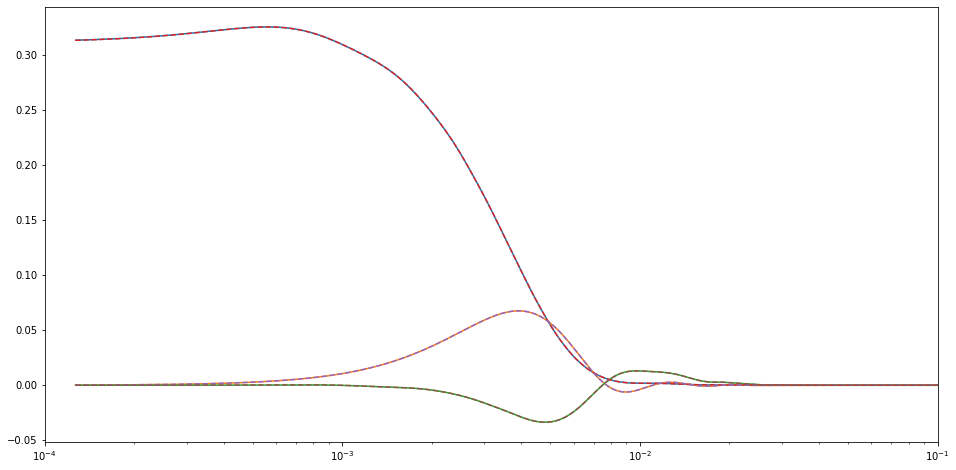

In [12]:
plt.figure(figsize=(16,8))
plt.semilogx(k0,W0/3)
plt.semilogx(k2,W2)
plt.semilogx(k4,W4)
plt.semilogx(k0b,W0b/3, '--')
plt.semilogx(k2b,W2b, '--')
plt.semilogx(k4b,W4b, '--')
plt.xlim(0.0001,0.1)
plt.show()

Text(0.5, 1.0, 'Speed (Lower is better)')

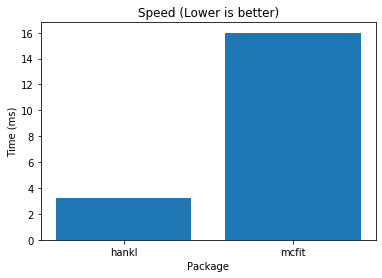

In [13]:
plt.bar(['hankl', 'mcfit'],[3.2, 16.0])
plt.xlabel("Package")
plt.ylabel("Time (ms)")
plt.title("Speed (Lower is better)")

In [15]:
%timeit r4, f_r4 = hankl.P2xi(k, W4, l=4)

3.62 ms ± 435 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
%timeit s4b, xi4b = mcfit.P2xi(k, l=4, lowring=True)(W4)

13.3 ms ± 2.1 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
r = np.logspace(-3,3,100)
xi = 1/ (1 + r*r)**1.5

In [25]:
k, P = hankl.xi2P(r, xi, l=0)

In [27]:
r_new, xi_new = hankl.P2xi(k, P, l=0)

In [29]:
np.allclose(r,r_new)

True

In [30]:
np.allclose(xi,xi_new)

True